In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, mean_squared_error

### letter recognition

In [2]:
from ucimlrepo import fetch_ucirepo

In [3]:
# fetch Xset 
letter_recognition = fetch_ucirepo(id=59) 
# X (as pandas Xframes) 
X = letter_recognition.data.features 
y = letter_recognition.data.targets 

In [4]:
# metaX 
print(letter_recognition.metaX) 
  
# variable information 
print(letter_recognition.variables) 

None
     name     role         type demographic                    description  \
0   lettr   Target  Categorical        None                 capital letter   
1   x-box  Feature      Integer        None     horizontal position of box   
2   y-box  Feature      Integer        None       vertical position of box   
3   width  Feature      Integer        None                   width of box   
4    high  Feature      Integer        None                  height of box   
5   onpix  Feature      Integer        None              total # on pixels   
6   x-bar  Feature      Integer        None     mean x of on pixels in box   
7   y-bar  Feature      Integer        None     mean y of on pixels in box   
8   x2bar  Feature      Integer        None                mean x variance   
9   y2bar  Feature      Integer        None                mean y variance   
10  xybar  Feature      Integer        None           mean x y correlation   
11  x2ybr  Feature      Integer        None              me

### Visualization

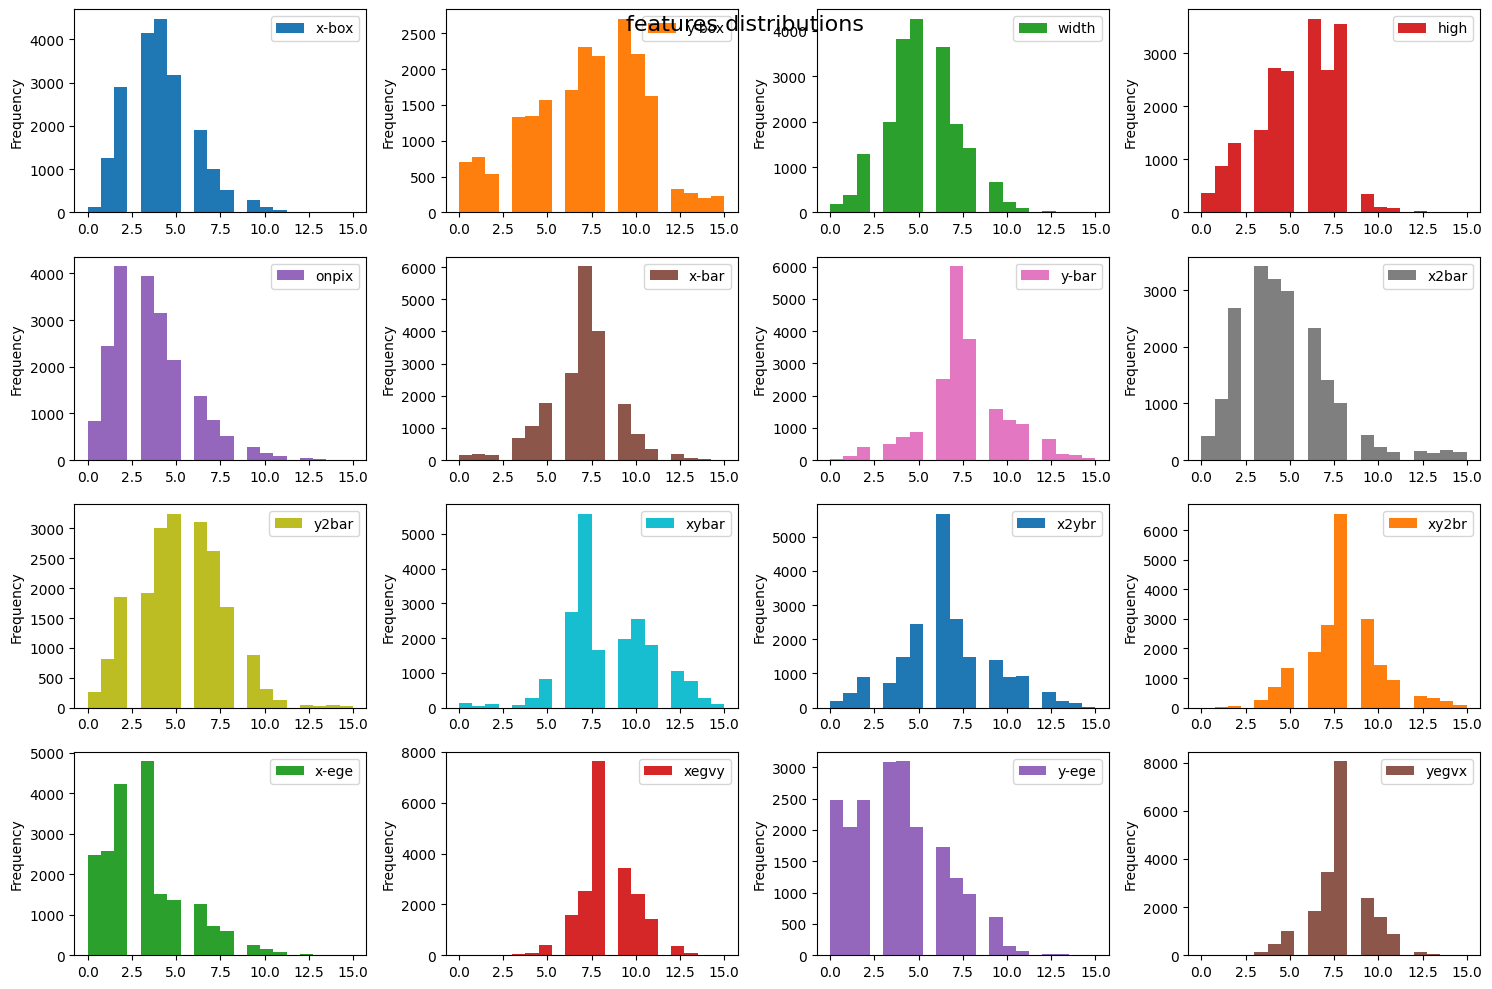

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

X.plot(kind="hist", bins=20, figsize=(15, 10), layout=(4, 4), subplots=True, sharex=False)
plt.tight_layout()
plt.suptitle("features distributions", fontsize=16)
plt.show()

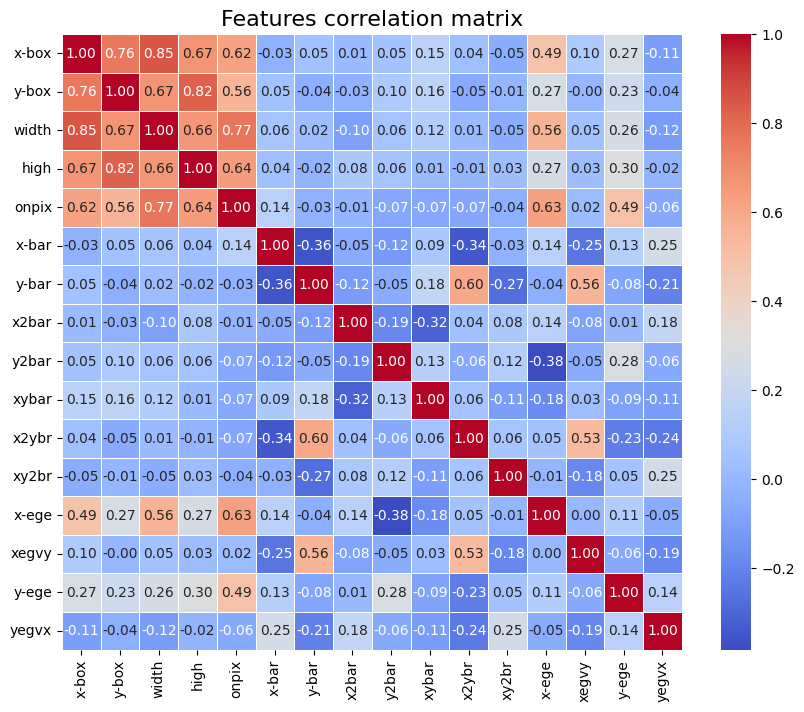

In [6]:
corr_matrix = X.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Features correlation matrix", fontsize=16)
plt.show()

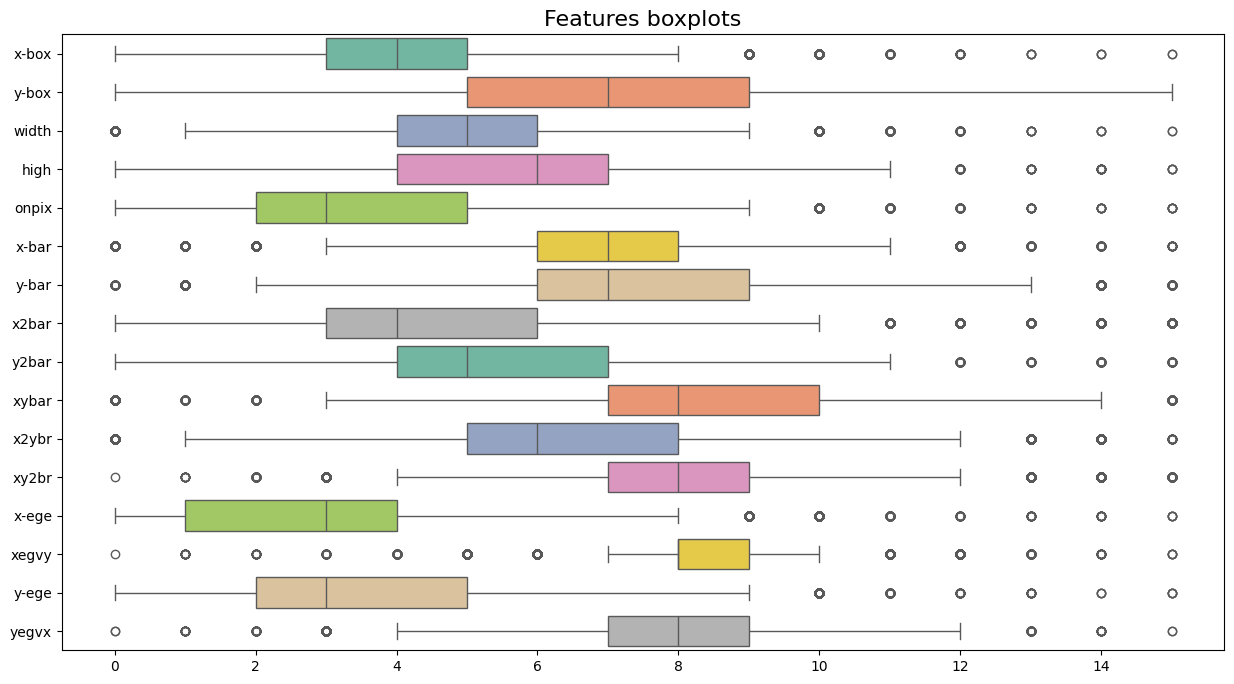

In [7]:
plt.figure(figsize=(15, 8))
sns.boxplot(data=X, orient="h", palette="Set2")
plt.title("Features boxplots", fontsize=16)
plt.show()

/tmp/ipykernel_72809/1791043912.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='lettr', data=y, palette="Set3", stat='probability')


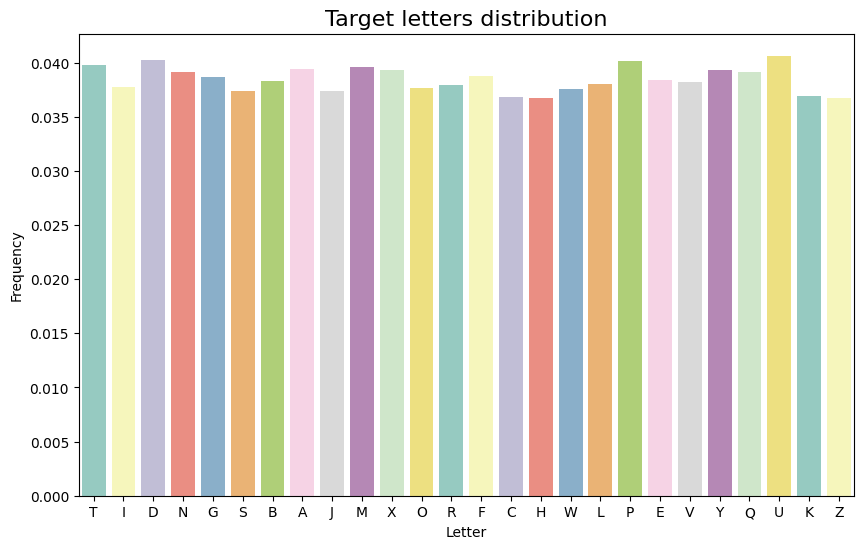

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x='lettr', data=y, palette="Set3", stat='probability')
plt.title("Target letters distribution", fontsize=16)
plt.xlabel("Letter")
plt.ylabel("Frequency")
plt.show()

### Kernel Performances

In [9]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y) 

/home/edwin/Projects/kernel/.venv/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
y_encoded

array([19,  8,  3, ..., 19, 18,  0], shape=(20000,))

In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform on training data
X_test = scaler.transform(X_test)       # Transform test data only

In [13]:
X_train.shape

(16000, 16)

### Performance

In [14]:
import sys
import os

# Dynamically determine the path to the 'src' directory
notebook_dir = os.path.dirname(os.path.abspath('__file__'))  # Current notebook directory
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))  # Move up one level
src_path = os.path.join(project_root, 'src')  # Path to src directory

# Add the src path to sys.path
sys.path.append(os.path.abspath(src_path))

In [15]:
from approximations import RandomFourierFeatures, NystromApproximation
from tasks import KernelRidgeRegression
from utils import *

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [17]:
import time
from memory_profiler import memory_usage

In [18]:
def measure_performances(func, *args, **kwargs):  # doest not allow the acces to the output of the function
    """
    Measures both memory usage and execution time of a function.
    
    Parameters:
    func: The function to execute.
    *args: Positional arguments for the function.
    **kwargs: Keyword arguments for the function.
    
    Returns:
    A tuple (memory_growth, execution_time):
        - memory_growth: Peak memory used by the function (in MiB).
        - execution_time: Time taken to execute the function (in seconds).
    """
    start_time = time.time()  # Record the start time
    mem_usage, result = memory_usage((func, args, kwargs), retval=True)  # Measure memory usage
    execution_time = time.time() - start_time  # Calculate elapsed time
    memory_growth = max(mem_usage) - min(mem_usage)  # Calculate memory growth
    return memory_growth, execution_time, result

In [19]:
# def profile_function(func, *args, **kwargs):
#     """
#     Profiles memory usage of a function and captures its return value.
    
#     :param func: The function to profile.
#     :param args: Positional arguments for the function.
#     :param kwargs: Keyword arguments for the function.
#     :return: Tuple of (memory_usage_list, function_result).
#     """
#     result_container = {}

#     def wrapper():
#         # Call the function and store the result in the container
#         result_container['result'] = func(*args, **kwargs)

#     # Monitor memory usage while executing the wrapper
#     start_time = time.time()
#     mem_usage = memory_usage(wrapper, retval=True, max_usage=True)
#     execution_time = time.time() - start_time

#     print("mem_usage", mem_usage)

#     memory_growth = max(mem_usage) - min(mem_usage)
#     return memory_growth, execution_time, result_container['result']

In [20]:
# Define a function to measure performance and store results in a DataFrame
def measure_and_store_performance(model_func, params, param_name="Number of components", model_name = None):
    results = []
    for param in params:
        memory_growth, execution_time, scores = measure_performances(model_func, param)
        accuracy, balanced_accuracy, f1 = scores[0], scores[1], scores[2]
        results.append({
            'Model' : f"{model_name}",
            f"{param_name}": "=" + str(param),
            'Clock Time (seconds)': execution_time,
            'Memory Usage (MiB)': memory_growth,
            'Accuracy': float(accuracy),
            'Balanced Accuracy': float(balanced_accuracy),
            'F1 Score': float(f1)
        })
    return pd.DataFrame(results)

In [21]:
def run_nystrom_model(n_components):
    # Nyström approximation    
    nystroem = NystromApproximation(kernel='rbf', gamma=1, n_components=n_components, random_state=42)

    X_train_nystroem = nystroem.fit_transform(X_train)
    X_test_nystroem = nystroem.transform(X_test)

    svm_nystrom = SVC(kernel='linear', C=1.0, random_state=42)
    svm_nystrom.fit(X_train_nystroem, y_train)

    y_pred_nystrom = svm_nystrom.predict(X_test_nystroem)

    return accuracy_score(y_test, y_pred_nystrom), balanced_accuracy_score(y_test, y_pred_nystrom), f1_score(y_test, y_pred_nystrom, average='macro')

In [40]:
def run_nystrom_baseline(n_components):
    from sklearn.kernel_approximation import Nystroem
    # Nyström approximation    
    nystroem = Nystroem(kernel='rbf', n_components=n_components, random_state=42)
    X_train_nystroem = nystroem.fit_transform(X_train)
    X_test_nystroem = nystroem.transform(X_test)

    svm_nystrom = SVC(kernel='linear', C=1.0, random_state=42)
    svm_nystrom.fit(X_train_nystroem, y_train)

    y_pred_nystrom = svm_nystrom.predict(X_test_nystroem)

    return accuracy_score(y_test, y_pred_nystrom), balanced_accuracy_score(y_test, y_pred_nystrom), f1_score(y_test, y_pred_nystrom, average='macro')

In [23]:
def run_rff_model(n_components):
    rff = RandomFourierFeatures(n_components=n_components, gamma=1.0, kernel='rbf', random_state=42)
    X_train_rff = rff.fit_transform(X_train)
    X_test_rff = rff.transform(X_test)

    svm_rff = SVC(kernel='linear', C=1.0, random_state=42)
    svm_rff.fit(X_train_rff, y_train)
    y_pred_rff = svm_rff.predict(X_test_rff)

    return accuracy_score(y_test, y_pred_rff), balanced_accuracy_score(y_test, y_pred_rff), f1_score(y_test, y_pred_rff, average='macro')

In [24]:
p_values = [1, 10, 100, 1000, 2000, 3000, 4000]

In [25]:
nytrsom_df = measure_and_store_performance(run_nystrom_model, p_values, model_name="Nystrom")

In [41]:
nytrsom_df

,Model,Number of components,Clock Time (seconds),Memory Usage (MiB),Accuracy,Balanced Accuracy,F1 Score
0,Nystrom,=1,6.955124,5.042969,0.03925,0.038734,0.003430
1,Nystrom,=10,10.482851,28.078125,0.05250,0.051751,0.027516
2,Nystrom,=100,27.071947,48.257812,0.14900,0.146495,0.162206
3,Nystrom,=1000,257.582823,325.578125,0.55050,0.553248,0.660151
4,Nystrom,=2000,509.603133,665.589844,0.68100,0.678501,0.752923
5,Nystrom,=3000,772.888602,896.261719,0.77400,0.772200,0.818572
6,Nystrom,=4000,1013.886205,1220.625000,0.79975,0.797386,0.836493


In [27]:
rff_df = measure_and_store_performance(run_rff_model, p_values, model_name="RFF")

In [28]:
rff_df

,Model,Number of components,Clock Time (seconds),Memory Usage (MiB),Accuracy,Balanced Accuracy,F1 Score
0,RFF,=1,7.108111,2.371094,0.04975,0.048166,0.007972
1,RFF,=10,10.928164,6.652344,0.07000,0.067817,0.051131
2,RFF,=100,19.041713,27.050781,0.24950,0.250557,0.246899
3,RFF,=1000,195.238727,336.292969,0.63925,0.639286,0.640187
4,RFF,=2000,325.481413,549.296875,0.75050,0.749846,0.750865
5,RFF,=3000,647.575965,1015.082031,0.78175,0.780808,0.781791
6,RFF,=4000,980.397037,1464.519531,0.81750,0.816223,0.817475


In [ ]:
nystrom_baseline_df = measure_and_store_performance(run_nystrom_baseline, p_values, model_name="Nystrom_baseline")

In [ ]:
nystrom_baseline_df

In [31]:
def run_baseline_kernel():
    # Complete kernel    
    gaussian_kernel = GaussianKernel(gamma=1)

    # Compute the full kernel matrices
    K_train = gaussian_kernel.get_Kxx(X_train)
    K_test = gaussian_kernel.get_Kxz(X_train, X_test)

    # Train the SVM using the precomputed kernel
    svm = SVC(kernel='precomputed', C=1.0, random_state=42)
    svm.fit(K_train, y_train)

    # Predict on the test set using the precomputed kernel
    y_pred = svm.predict(K_test.T)

    return accuracy_score(y_test, y_pred), balanced_accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro')

In [32]:
baseline_mem_usage, baseline_clock_time, scores = measure_performances(run_baseline_kernel)
accuracy, balanced_accuracy, f1 = scores[0], scores[1], scores[2]

baseline_df = pd.DataFrame([{
    'Model': 'Baseline',
    'Clock Time (seconds)': baseline_clock_time,
    'Memory Usage (MiB)': baseline_mem_usage,
    'Accuracy': float(accuracy),
    'Balanced Accuracy': float(balanced_accuracy),
    'F1 Score': float(f1)
}])

In [33]:
def run_baseline_kernel_sklearn():
    # Train the SVM
    svm = SVC(kernel='rbf', C=1.0, random_state=42)
    svm.fit(X_train, y_train)

    # Predict on the test set using the precomputed kernel
    y_pred = svm.predict(X_test)

    return accuracy_score(y_test, y_pred), balanced_accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='macro')

In [34]:
baseline_mem_usage, baseline_clock_time, scores = measure_performances(run_baseline_kernel_sklearn)
accuracy, balanced_accuracy, f1 = scores[0], scores[1], scores[2]

baseline_sklearn_df = pd.DataFrame([{
    'Model': ' Sklearn',
    'Clock Time (seconds)': baseline_clock_time,
    'Memory Usage (MiB)': baseline_mem_usage,
    'Accuracy': float(accuracy),
    'Balanced Accuracy': float(balanced_accuracy),
    'F1 Score': float(f1)
}])

In [35]:
baseline_sklearn_df

,Model,Clock Time (seconds),Memory Usage (MiB),Accuracy,Balanced Accuracy,F1 Score
0,Sklearn,3.425596,0.003906,0.95,0.949166,0.94929


In [36]:
# Combine both DataFrames
nytrsom_vs_baseline = pd.concat([baseline_df, nytrsom_df], ignore_index=True)

In [37]:
nytrsom_vs_baseline

,Model,Clock Time (seconds),Memory Usage (MiB),Accuracy,Balanced Accuracy,F1 Score,Number of components
0,Baseline,1097.317890,2929.515625,0.94550,0.944334,0.947463,NaN
1,Nystrom,6.955124,5.042969,0.03925,0.038734,0.003430,=1
2,Nystrom,10.482851,28.078125,0.05250,0.051751,0.027516,=10
3,Nystrom,27.071947,48.257812,0.14900,0.146495,0.162206,=100
4,Nystrom,257.582823,325.578125,0.55050,0.553248,0.660151,=1000
5,Nystrom,509.603133,665.589844,0.68100,0.678501,0.752923,=2000
6,Nystrom,772.888602,896.261719,0.77400,0.772200,0.818572,=3000
7,Nystrom,1013.886205,1220.625000,0.79975,0.797386,0.836493,=4000


In [38]:
# Combine both DataFrames
rff_vs_baseline = pd.concat([baseline_df, rff_df], ignore_index=True)

In [39]:
rff_vs_baseline

,Model,Clock Time (seconds),Memory Usage (MiB),Accuracy,Balanced Accuracy,F1 Score,Number of components
0,Baseline,1097.317890,2929.515625,0.94550,0.944334,0.947463,NaN
1,RFF,7.108111,2.371094,0.04975,0.048166,0.007972,=1
2,RFF,10.928164,6.652344,0.07000,0.067817,0.051131,=10
3,RFF,19.041713,27.050781,0.24950,0.250557,0.246899,=100
4,RFF,195.238727,336.292969,0.63925,0.639286,0.640187,=1000
5,RFF,325.481413,549.296875,0.75050,0.749846,0.750865,=2000
6,RFF,647.575965,1015.082031,0.78175,0.780808,0.781791,=3000
7,RFF,980.397037,1464.519531,0.81750,0.816223,0.817475,=4000
